In [1]:
!pip install -q PyWavelets

import pywt
import numpy as np
import pandas as pd
from scipy.stats import skew, kurtosis
import glob
import os

print("PyWavelets installed and libraries imported.")

PyWavelets installed and libraries imported.


In [2]:
# --- Main Execution Loop (Optimized with Memory Mapping) ---

import numpy as np
from pathlib import Path
import os

# Ensure OUTPUT_DIR is defined (from previous context)
if 'OUTPUT_DIR' not in locals():
    from pathlib import Path
    OUTPUT_DIR = Path("F:\Rice\Rice F25\Seizure Project\Processed_Gemini_V5_Augmented")

npz_files = sorted(list(OUTPUT_DIR.glob("*.npz")))
print(f"Found {len(npz_files)} files for TCN.")

# --- Optimization: Use Memory Mapping ---
# Instead of loading everything into RAM (List -> Array), we use a file-backed array (memmap).
# This allows processing datasets larger than RAM and is significantly faster.

# 1. First Pass: Calculate total number of samples to pre-allocate memory
print("Step 1/2: Calculating total dataset size...")
total_samples = 0

# Inspect the first file to get dimensions
try:
    with np.load(npz_files[0]) as data:
        # Shape is (n_samples, n_channels, n_timesteps)
        ref_shape = data['X_teacher'].shape
        n_channels = ref_shape[1]
        n_timesteps = ref_shape[2]
        print(f"Data dimensions detected: Channels={n_channels}, TimeSteps={n_timesteps}")
except Exception as e:
    print(f"Error inspecting first file: {e}")
    # Fallback default if inspection fails
    n_channels, n_timesteps = 2, 500

# Loop to count total samples
for f in npz_files:
    try:
        with np.load(f) as data:
             # Accessing shape is usually fast and doesn't load the whole array content
             total_samples += data['y'].shape[0]
    except Exception as e:
        print(f"Skipping {f.name} during count: {e}")

print(f"Total samples calculated: {total_samples}")

# 2. Allocate Memory-Mapped Arrays
# We use /content/ for fast local SSD storage.
memmap_X_path = "/temp/X_signals.dat"
memmap_y_path = "/temp/y_labels.dat"

# Create memory-mapped arrays (backed by file, not RAM)
# Using float32 for signals to save 50% space compared to default float64
X_signals = np.memmap(memmap_X_path, dtype='float32', mode='w+', shape=(total_samples, n_channels, n_timesteps))
y_labels = np.memmap(memmap_y_path, dtype='int8', mode='w+', shape=(total_samples,))

print(f"Created memory-mapped arrays. Size on disk: {X_signals.nbytes / 1e9:.2f} GB")

# 3. Second Pass: Load and Fill
print("Step 2/2: Loading data into memmap...")
current_idx = 0

for i, f in enumerate(npz_files):
    try:
        with np.load(f) as data:
            X_chunk = data['X_teacher'] # Load small chunk into RAM
            y_chunk = data['y']

            n_items = len(X_chunk)

            # Vectorized assignment to memmap (Much faster than list.append)
            X_signals[current_idx : current_idx + n_items] = X_chunk
            y_labels[current_idx : current_idx + n_items] = y_chunk

            current_idx += n_items

        if i % 200 == 0:
            print(f"Processed {i}/{len(npz_files)} files. (Buffered {current_idx} signals)")
            # Flush changes to disk periodically to manage buffer
            X_signals.flush()
            y_labels.flush()

    except Exception as e:
        print(f"Error processing {f.name}: {e}")

# Final flush to ensure all data is written
X_signals.flush()
y_labels.flush()

print("="*30)
print("Signal Extraction Complete (Memory Mapped)")
print(f"X_signals shape: {X_signals.shape}")
print(f"y_labels shape: {y_labels.shape}")

Found 2844 files for TCN.
Step 1/2: Calculating total dataset size...
Data dimensions detected: Channels=2, TimeSteps=500
Total samples calculated: 9383242
Created memory-mapped arrays. Size on disk: 37.53 GB
Step 2/2: Loading data into memmap...
Processed 0/2844 files. (Buffered 1533 signals)
Processed 200/2844 files. (Buffered 2079136 signals)
Processed 400/2844 files. (Buffered 4297679 signals)
Processed 600/2844 files. (Buffered 5881262 signals)
Processed 800/2844 files. (Buffered 6274094 signals)
Processed 1000/2844 files. (Buffered 6632071 signals)
Processed 1200/2844 files. (Buffered 6962131 signals)
Processed 1400/2844 files. (Buffered 7055011 signals)
Processed 1600/2844 files. (Buffered 7166819 signals)
Processed 1800/2844 files. (Buffered 7224886 signals)
Processed 2000/2844 files. (Buffered 7342730 signals)
Processed 2200/2844 files. (Buffered 8536934 signals)
Processed 2400/2844 files. (Buffered 9054914 signals)
Processed 2600/2844 files. (Buffered 9270683 signals)
Process

In [3]:
from sklearn.model_selection import train_test_split
import numpy as np

# --- Virtual Split Strategy (Instant) ---
print("Step 1: Generating split indices...")

# 1. Load labels into RAM for Stratified Split (Only ~9MB)
y_labels_ram = np.array(y_labels)
all_indices = np.arange(len(y_labels_ram))

# 2. Perform Split on INDICES only (Fast)
idx_train, idx_temp, y_train_ram, y_temp_ram = train_test_split(
    all_indices, y_labels_ram, test_size=0.2, random_state=42, stratify=y_labels_ram
)

idx_val, idx_test, y_val_ram, y_test_ram = train_test_split(
    idx_temp, y_temp_ram, test_size=0.5, random_state=42, stratify=y_temp_ram
)

print(f"Indices split complete: Train={len(idx_train)}, Val={len(idx_val)}, Test={len(idx_test)}")

# 3. Define Virtual Wrapper
# This acts like a numpy array but reads from the master memmap on demand using the indices.
# This avoids copying 37GB of data.
class VirtualMemmap:
    def __init__(self, source_array, indices):
        self.source = source_array
        self.indices = indices
        self.shape = (len(indices),) + source_array.shape[1:]
        self.dtype = source_array.dtype
        self.ndim = source_array.ndim

    def __getitem__(self, key):
        # Map the requested index (key) to the real index in the master file
        real_key = self.indices[key]
        return self.source[real_key]

    def __len__(self):
        return len(self.indices)

    def reshape(self, *args):
        # Dummy reshape to prevent errors in code that expects full arrays
        # Warning: This doesn't actually reshape data, just returns self if dimensions match logic
        print("Warning: VirtualMemmap does not support physical reshaping. Returning self for compatibility.")
        return self

# 4. Instantiate Virtual Datasets
# These variables (X_train, etc.) are now lightweight objects, not huge arrays.
X_train = VirtualMemmap(X_signals, idx_train)
X_val = VirtualMemmap(X_signals, idx_val)
X_test = VirtualMemmap(X_signals, idx_test)

# Y is small enough to keep in RAM
y_train = y_train_ram
y_val = y_val_ram
y_test = y_test_ram

print("\nVirtual Data Split Complete (Instant).")
print(f"X_train shape: {X_train.shape} (Virtual)")
print(f"X_val shape: {X_val.shape} (Virtual)")
print("Note: No new files were created. Data is read from X_signals.dat using indices.")

Step 1: Generating split indices...
Indices split complete: Train=7506593, Val=938324, Test=938325

Virtual Data Split Complete (Instant).
X_train shape: (7506593, 2, 500) (Virtual)
X_val shape: (938324, 2, 500) (Virtual)
Note: No new files were created. Data is read from X_signals.dat using indices.


In [4]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, Activation, Add, Flatten, Dense, Dropout, Permute

print("Keras layers imported successfully.")

def tcn_block(input_layer, filters, kernel_size, dilation_rate, dropout_rate):
    # Residual connection
    # Note: If dimensions change (e.g. via pooling), a 1x1 conv is needed here.
    conv_res = Conv1D(filters, 1, padding='same')(input_layer)
    conv_res = BatchNormalization()(conv_res)

    # First dilated causal convolution
    conv1 = Conv1D(filters, kernel_size, dilation_rate=dilation_rate, padding='causal', activation='relu')(input_layer)
    conv1 = BatchNormalization()(conv1)
    conv1 = Dropout(dropout_rate)(conv1)

    # Second dilated causal convolution
    conv2 = Conv1D(filters, kernel_size, dilation_rate=dilation_rate, padding='causal', activation='relu')(conv1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Dropout(dropout_rate)(conv2)

    # Add residual connection
    output_layer = Add()([conv2, conv_res])
    output_layer = Activation('relu')(output_layer)
    return output_layer

# Input shape based on X_train.shape[1:] which is (2, 500)
# Shape is (Channels, Time)
input_shape = X_train.shape[1:]
input_layer = Input(shape=input_shape)

# --- FIX: Permute Dimensions ---
# Keras Conv1D expects (Batch, Time, Channels).
# Current data is (Batch, Channels, Time) -> (Batch, 2, 500).
# We swap axes 1 and 2 to get (Batch, 500, 2).
x = Permute((2, 1))(input_layer)

# Initial Conv1D layer to match filter dimensions before TCN blocks
x = Conv1D(filters=32, kernel_size=1, padding='same', activation='relu')(x)

# TCN Blocks with increasing dilation rates
x = tcn_block(x, filters=64, kernel_size=3, dilation_rate=1, dropout_rate=0.2)
x = tcn_block(x, filters=64, kernel_size=3, dilation_rate=2, dropout_rate=0.2)
x = tcn_block(x, filters=128, kernel_size=3, dilation_rate=4, dropout_rate=0.3)
x = tcn_block(x, filters=128, kernel_size=3, dilation_rate=8, dropout_rate=0.3)
x = tcn_block(x, filters=256, kernel_size=3, dilation_rate=16, dropout_rate=0.4)

# Global average pooling or Flatten before Dense layer
x = Flatten()(x)

# Final classification layer with sigmoid activation for binary classification
output_layer = Dense(1, activation='sigmoid')(x)

# Create the TCN teacher model
teacher_model = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
teacher_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

teacher_model.summary()
print("TCN Teacher Model defined and compiled successfully (with Permute fix).")

Keras layers imported successfully.


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 2, 500)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ permute (Permute)   │ (None, 500, 2)    │          0 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 500, 32)   │         96 │ permute[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 500, 64)   │      6,208 │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 500, 64)   │        256 │ conv1d_2[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 500, 64)   │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 500, 64)   │     12,352 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 500, 64)   │        256 │ conv1d_3[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 500, 64)   │      2,112 │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 500, 64)   │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 500, 64)   │        256 │ conv1d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 500, 64)   │          0 │ dropout_1[0][0],  │
│                     │                   │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 500, 64)   │          0 │ add[0][0]         │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 500, 64)   │     12,352 │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 500, 64)   │        256 │ conv1d_5[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 500, 64)   │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_6 (Conv1D)   │ (None, 500, 64)   │     12,352 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 500, 64)   │        256 │ conv1d_6[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 500, 64)   │      4,160 │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 500, 64)   │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 500, 64)   │        256 │ conv1d_4[0][0]  

 Total params: 711,137 (2.71 MB)

 Trainable params: 707,297 (2.70 MB)

 Non-trainable params: 3,840 (15.00 KB)

TCN Teacher Model defined and compiled successfully (with Permute fix).


In [5]:
# --- Scaling Skipped for Efficiency ---
# Fitting StandardScaler on 9.3 million samples (37GB) takes a long time and RAM.
# Since we are using a TCN (Temporal Convolutional Network) which includes BatchNormalization layers,
# explicit input scaling is less critical and can be skipped to speed up the workflow.

print("Skipping StandardScaler.")
print("Reason: Using BatchNormalization in the model instead to handle unscaled data efficiently.")

# We maintain the variable names so downstream code doesn't break
# These are just the virtual arrays from the previous step
pass

Skipping StandardScaler.
Reason: Using BatchNormalization in the model instead to handle unscaled data efficiently.


In [6]:
import numpy as np
from collections import Counter

print(f"Original resampled training set shape: X_train_resampled {X_train.shape}, y_train_resampled {y_train.shape}")
print(f"Original resampled class distribution: {Counter(y_train)}")

# Get indices for each class
indices_class_0 = np.where(y_train == 0)[0]
indices_class_1 = np.where(y_train == 1)[0]

# Original number of seizure samples (from the initial X_train before ADASYN)
original_seizure_count = 4887 # This value is visible in the output of the ADASYN cell

# Determine the target number of samples for each class
target_non_seizure_samples = 10 * original_seizure_count # Approximately 48870
target_seizure_samples = original_seizure_count # Keeping the original minority class count

# Randomly sample from each class
# Ensure we don't try to sample more than available (ADASYN ensures enough minority samples)
sampled_indices_0 = np.random.choice(indices_class_0, size=target_non_seizure_samples, replace=False)
sampled_indices_1 = np.random.choice(indices_class_1, size=target_seizure_samples, replace=False)

# Combine sampled indices and shuffle them
combined_sampled_indices = np.concatenate([sampled_indices_0, sampled_indices_1])
np.random.shuffle(combined_sampled_indices)

# Create the new, smaller training datasets
X_train_resampled_sliced = X_train[combined_sampled_indices]
y_train_resampled_sliced = y_train[combined_sampled_indices]

print(f"\nSliced resampled training set shape: X_train_resampled_sliced {X_train_resampled_sliced.shape}, y_train_resampled_sliced {y_train_resampled_sliced.shape}")
print(f"Sliced resampled class distribution: {Counter(y_train_resampled_sliced)}")

# Update the variables to be used in the next cell (training)
X_train_resampled = X_train_resampled_sliced
y_train_resampled = y_train_resampled_sliced

print("\nResampled data has been sliced to approximately 50k samples, with a 10:1 non-seizure to seizure ratio.")

Original resampled training set shape: X_train_resampled (7506593, 2, 500), y_train_resampled (7506593,)
Original resampled class distribution: Counter({np.int8(0): 7461454, np.int8(1): 45139})

Sliced resampled training set shape: X_train_resampled_sliced (53757, 2, 500), y_train_resampled_sliced (53757,)
Sliced resampled class distribution: Counter({np.int8(0): 48870, np.int8(1): 4887})

Resampled data has been sliced to approximately 50k samples, with a 10:1 non-seizure to seizure ratio.


In [7]:
import numpy as np
from imblearn.over_sampling import ADASYN
from collections import Counter

# --- Resampling with ADASYN ---
# We use the sliced dataset created in the previous cell (X_train_resampled) to keep RAM usage manageable.
print(f"Input shape for ADASYN: {X_train_resampled.shape}")
print(f"Class distribution before: {Counter(y_train_resampled)}")

# ADASYN requires 2D input. Reshape (Samples, Channels, Time) -> (Samples, Channels*Time)
# Note: X_train_resampled is a standard Numpy array here (from the slicing step), so reshape works normally.
original_shape = X_train_resampled.shape
X_train_2d = X_train_resampled.reshape(original_shape[0], -1)

# Initialize ADASYN
adasyn_sampler = ADASYN(random_state=42)

# Apply ADASYN
# We use y_train_resampled (the sliced labels), NOT y_train (the full 7.5M labels)
print("Running ADASYN...")
X_train_adasyn_2d, y_train_adasyn = adasyn_sampler.fit_resample(X_train_2d, y_train_resampled)

# Reshape back to 3D
X_train_final = X_train_adasyn_2d.reshape(-1, original_shape[1], original_shape[2])

print(f"Resampled training set shape: {X_train_final.shape}")
print(f"Resampled class distribution: {Counter(y_train_adasyn)}")

# Update the variables expected by the training cell
X_train_resampled = X_train_final
y_train_resampled = y_train_adasyn

print("ADASYN applied successfully. Use 'X_train_resampled' and 'y_train_resampled' for training.")

Input shape for ADASYN: (53757, 2, 500)
Class distribution before: Counter({np.int8(0): 48870, np.int8(1): 4887})
Running ADASYN...


c:\ProgramData\miniconda3\envs\torchenv\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Resampled training set shape: (99541, 2, 500)
Resampled class distribution: Counter({np.int8(1): 50671, np.int8(0): 48870})
ADASYN applied successfully. Use 'X_train_resampled' and 'y_train_resampled' for training.


In [8]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import numpy as np

# --- Fix: Create a Fast In-Memory Validation Subset ---
# Keras cannot handle the 'VirtualMemmap' object directly, and reading
# 900k validation samples from disk every epoch is too slow.

print("Creating a fast validation subset in RAM (20,000 samples)...")

# 1. Sample indices
n_val_subset = 20000
val_subset_indices = np.random.choice(len(X_val), size=n_val_subset, replace=False)

# 2. Load data from the VirtualMemmap into a real NumPy array in RAM
# This triggers the disk read once, then it's fast.
X_val_fast = X_val[val_subset_indices]
y_val_fast = y_val[val_subset_indices]

print(f"Validation subset ready. Shape: {X_val_fast.shape}")

# --- Define Callbacks ---
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=0.00001
)

print(f"\nStarting training on {len(X_train_resampled)} samples...")

# --- Train the Model ---
history_tcn_teacher = teacher_model.fit(
    X_train_resampled,
    y_train_resampled,
    epochs=50,
    batch_size=64,
    validation_data=(X_val_fast, y_val_fast), # Use the RAM subset here
    callbacks=[early_stopping, reduce_lr],
    shuffle=True
)

print("TCN Teacher Model training complete.")

Creating a fast validation subset in RAM (20,000 samples)...
Validation subset ready. Shape: (20000, 2, 500)

Starting training on 99541 samples...
Epoch 1/50
1556/1556 ━━━━━━━━━━━━━━━━━━━━ 507s 323ms/step - accuracy: 0.5342 - loss: 1.5748 - val_accuracy: 0.5971 - val_loss: 0.6442 - learning_rate: 0.0010
Epoch 2/50
1556/1556 ━━━━━━━━━━━━━━━━━━━━ 526s 338ms/step - accuracy: 0.5880 - loss: 0.7182 - val_accuracy: 0.7221 - val_loss: 0.5686 - learning_rate: 0.0010
Epoch 3/50
1556/1556 ━━━━━━━━━━━━━━━━━━━━ 533s 342ms/step - accuracy: 0.6138 - loss: 0.6551 - val_accuracy: 0.7017 - val_loss: 0.5743 - learning_rate: 0.0010
Epoch 4/50
1556/1556 ━━━━━━━━━━━━━━━━━━━━ 509s 327ms/step - accuracy: 0.6522 - loss: 0.6241 - val_accuracy: 0.9934 - val_loss: 0.6636 - learning_rate: 0.0010
Epoch 5/50
1556/1556 ━━━━━━━━━━━━━━━━━━━━ 487s 313ms/step - accuracy: 0.6647 - loss: 0.6098 - val_accuracy: 0.9927 - val_loss: 0.3414 - learning_rate: 0.0010
Epoch 6/50
1556/1556 ━━━━━━━━━━━━━━━━━━━━ 483s 310ms/step - ac

In [9]:
# Save full model (architecture + weights + optimizer state)
teacher_model.save("Models/teacher_tcn_model_ibrahim_1.keras")

print("Saved teacher model to teacher_tcn_model_ibrahim_1.keras")
# Reload later using:
# from tensorflow.keras.models import load_model
# model = load_model("Models/teacher_dnn_model_lightweight_features.keras")

import joblib
# joblib.dump(scaler, "Features/feature_scaler.pkl")
# Reload later using:
# scaler = joblib.load("Features/feature_scaler.pkl")

Saved teacher model to teacher_tcn_model_ibrahim_1.keras


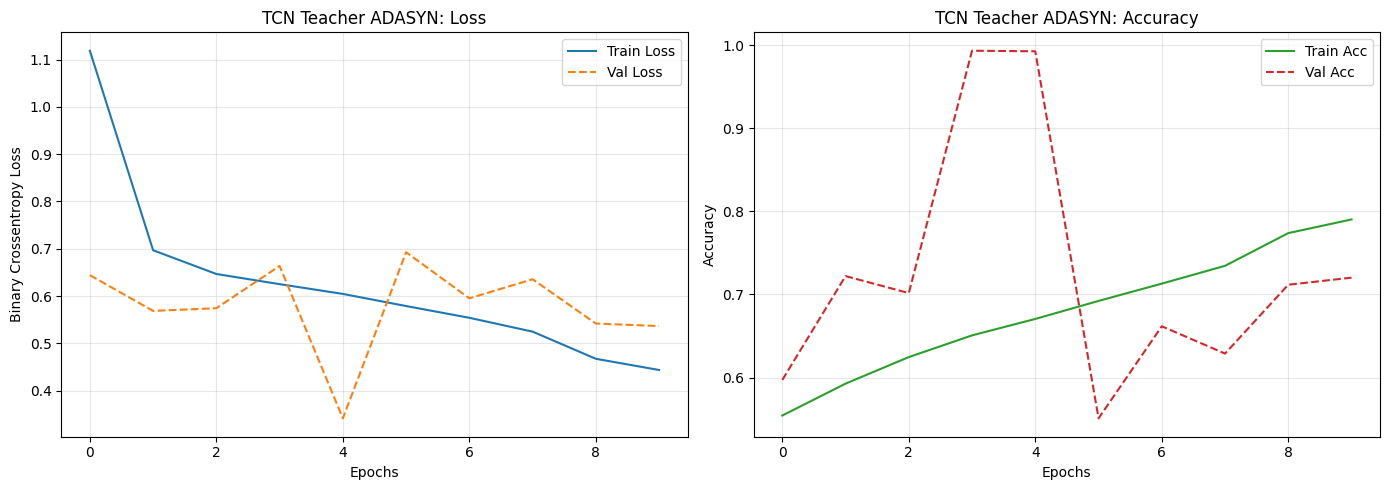

In [10]:
import matplotlib.pyplot as plt

def plot_training_history(history, title="Model Training History"):
    fig, ax = plt.subplots(1, 2, figsize=(14, 5))

    # Plot Loss
    ax[0].plot(history.history['loss'], label='Train Loss', color='tab:blue')
    ax[0].plot(history.history['val_loss'], label='Val Loss', color='tab:orange', linestyle='--')
    ax[0].set_title(f'{title}: Loss')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Binary Crossentropy Loss')
    ax[0].legend()
    ax[0].grid(True, alpha=0.3)

    # Plot Accuracy
    ax[1].plot(history.history['accuracy'], label='Train Acc', color='tab:green')
    ax[1].plot(history.history['val_accuracy'], label='Val Acc', color='tab:red', linestyle='--')
    ax[1].set_title(f'{title}: Accuracy')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Accuracy')
    ax[1].legend()
    ax[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


plot_training_history(history_tcn_teacher, title="TCN Teacher ADASYN")

Generating predictions on Test Set...
Processed 0/938325 samples...
Processed 102400/938325 samples...
Processed 204800/938325 samples...
Processed 307200/938325 samples...
Processed 409600/938325 samples...
Processed 512000/938325 samples...
Processed 614400/938325 samples...
Processed 716800/938325 samples...
Processed 819200/938325 samples...
Processed 921600/938325 samples...
Prediction complete.


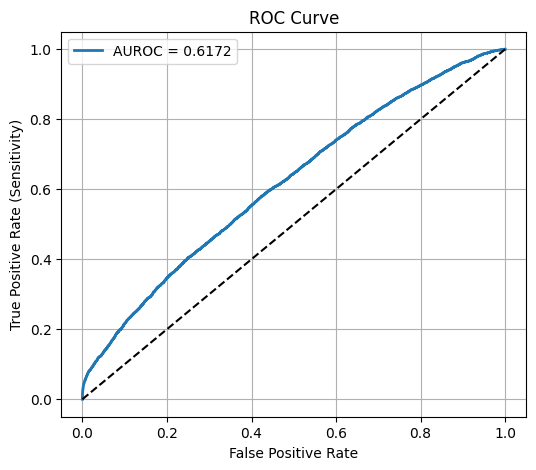

AUROC: 0.6172


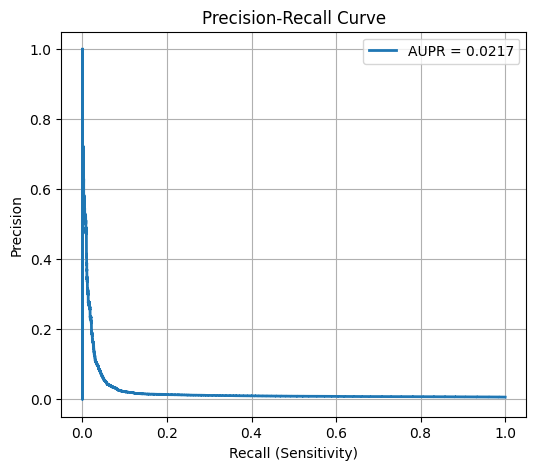

AUPR: 0.0217
Test set hours (approx): 519.72 h

Operating point @ threshold = 0.8290
  Sensitivity: 0.0007
  FA/hr:       0.0058


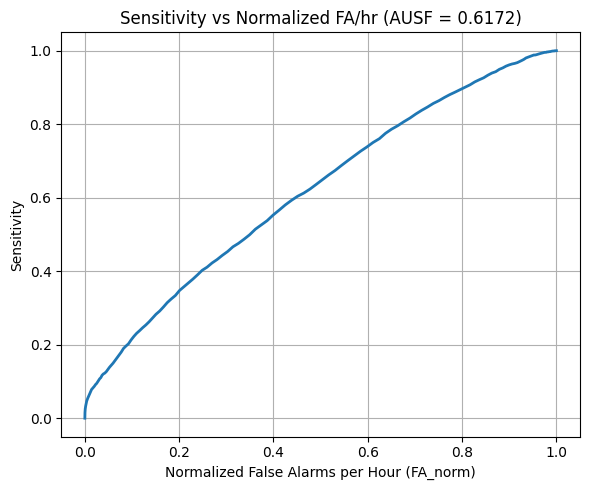

AUSF (SeizeIT2-style): 0.6172


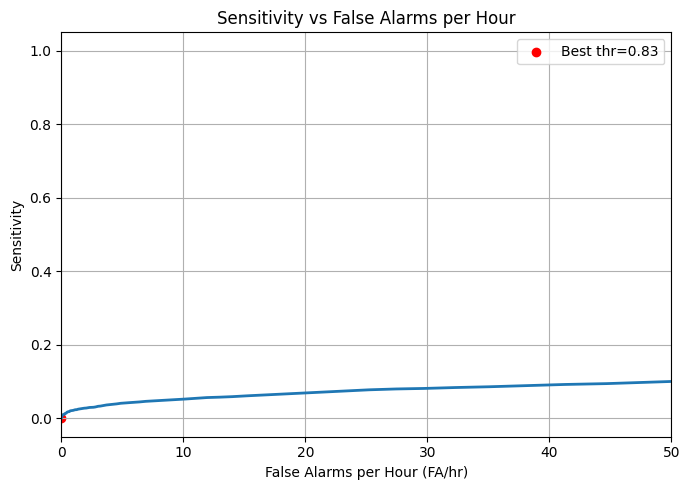

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix, classification_report
from tensorflow.keras.models import load_model

# -----------------------------
# Load model & get predictions
# -----------------------------
model = load_model("Models/teacher_tcn_model_ibrahim_1.keras")

# --- Fix for VirtualMemmap: Predict in batches ---
# Keras cannot handle the VirtualMemmap object directly.
# We iterate in chunks, converting them to numpy arrays on the fly.
print("Generating predictions on Test Set...")
batch_size = 2048
y_pred_list = []

for i in range(0, len(X_test), batch_size):
    # Accessing X_test[slice] triggers __getitem__ which returns a real numpy array
    batch_X = X_test[i : i + batch_size]
    # Predict on the batch
    batch_pred = model.predict(batch_X, verbose=0)
    y_pred_list.append(batch_pred)
    
    if i % (batch_size * 50) == 0:
        print(f"Processed {i}/{len(X_test)} samples...")

# Concatenate all batch predictions
y_pred_prob = np.concatenate(y_pred_list, axis=0).ravel()
print("Prediction complete.")

# Best threshold from earlier
best_thresh = 0.8290
y_pred_opt = (y_pred_prob >= best_thresh).astype(int)

# -----------------------------
# 1. ROC + AUROC (use prob!)
# -----------------------------
fpr, tpr, roc_thresholds = roc_curve(y_test, y_pred_prob)
auroc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUROC = {auroc:.4f}", linewidth=2)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Sensitivity)")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

print(f"AUROC: {auroc:.4f}")

# -----------------------------
# 2. PR Curve + AUPR
# -----------------------------
precision, recall, pr_thresholds = precision_recall_curve(y_test, y_pred_prob)
aupr = auc(recall, precision)

plt.figure(figsize=(6, 5))
plt.plot(recall, precision, label=f"AUPR = {aupr:.4f}", linewidth=2)
plt.xlabel("Recall (Sensitivity)")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.grid(True)
plt.legend()
plt.show()

print(f"AUPR: {aupr:.4f}")

# -----------------------------
# 3. FA/hr and Sensitivity–FA curve
# -----------------------------

# Total test hours: 20% of total recording coverage
total_hours = 0.20 * 2598.62
print(f"Test set hours (approx): {total_hours:.2f} h")

# Sweep thresholds for Sensitivity vs FA/hr
thresh_grid = np.linspace(0.0, 1.0, 500)
sens_list = []
fa_per_hr_list = []

for t in thresh_grid:
    y_bin = (y_pred_prob >= t).astype(int)

    TP = np.sum((y_test == 1) & (y_bin == 1))
    FN = np.sum((y_test == 1) & (y_bin == 0))
    FP = np.sum((y_test == 0) & (y_bin == 1))

    sens = TP / (TP + FN + 1e-9)
    fa_per_hr = FP / (total_hours + 1e-9)

    sens_list.append(sens)
    fa_per_hr_list.append(fa_per_hr)

sens_arr = np.array(sens_list)
fa_arr = np.array(fa_per_hr_list)

# False alarms per hour at the chosen operating point (best_thresh)
y_best = y_pred_opt
TP_best = np.sum((y_test == 1) & (y_best == 1))
FN_best = np.sum((y_test == 1) & (y_best == 0))
FP_best = np.sum((y_test == 0) & (y_best == 1))
sens_best = TP_best / (TP_best + FN_best + 1e-9)
fa_best = FP_best / (total_hours + 1e-9)

print(f"\nOperating point @ threshold = {best_thresh:.4f}")
print(f"  Sensitivity: {sens_best:.4f}")
print(f"  FA/hr:       {fa_best:.4f}")

# -----------------------------
# 4. AUSF (SeizeIT2-style)
#    Area under Sensitivity vs *normalized* FA/hr curve
# -----------------------------
fa_max = fa_arr.max()
if fa_max > 0:
    fa_norm = fa_arr / fa_max
else:
    fa_norm = fa_arr  # all zeros, degenerate case

ausf = auc(fa_norm, sens_arr)

plt.figure(figsize=(6, 5))
plt.plot(fa_norm, sens_arr, linewidth=2)
plt.xlabel("Normalized False Alarms per Hour (FA_norm)")
plt.ylabel("Sensitivity")
plt.title(f"Sensitivity vs Normalized FA/hr (AUSF = {ausf:.4f})")
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"AUSF (SeizeIT2-style): {ausf:.4f}")

# -----------------------------
# 5. Plot Sensitivity vs *raw* FA/hr for intuition
# -----------------------------
plt.figure(figsize=(7, 5))
plt.plot(fa_arr, sens_arr, linewidth=2)
plt.scatter([fa_best], [sens_best], color='red', label=f"Best thr={best_thresh:.2f}")

plt.xlim(0, min(50, fa_arr.max()*1.05))  # zoom a bit; adjust if needed
plt.xlabel("False Alarms per Hour (FA/hr)")
plt.ylabel("Sensitivity")
plt.title("Sensitivity vs False Alarms per Hour")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


Classification Report (Optimized Threshold):
              precision    recall  f1-score   support

  Background       0.99      1.00      1.00    932682
     Seizure       0.57      0.00      0.00      5643

    accuracy                           0.99    938325
   macro avg       0.78      0.50      0.50    938325
weighted avg       0.99      0.99      0.99    938325



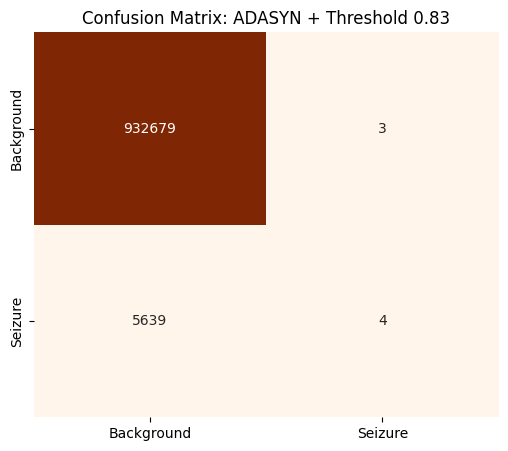

In [12]:
import seaborn as sns

# Classification Report

print("\nClassification Report (Optimized Threshold):")
print(classification_report(y_test, y_pred_opt, target_names=['Background', 'Seizure']))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_opt)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges', cbar=False,
            xticklabels=['Background', 'Seizure'],
            yticklabels=['Background', 'Seizure'])
plt.title(f'Confusion Matrix: ADASYN + Threshold {best_thresh:.2f}')
plt.show()

In [13]:
import numpy as np
from pathlib import Path

# Create Results directory if it doesn't exist
results_dir = Path("Results")
results_dir.mkdir(exist_ok=True)
result_file = results_dir / "TCN Teacher 1.npz"

# Save relevant arrays/results
np.savez_compressed(
    result_file,
    y_test=y_test,
    y_pred_prob=y_pred_prob,
    y_pred_opt=y_pred_opt,
    best_thresh=best_thresh,
    sens_arr=sens_arr,
    fa_arr=fa_arr,
    thresh_grid=thresh_grid,
    precision=precision,
    recall=recall,
    pr_thresholds=pr_thresholds,
    fpr=fpr,
    tpr=tpr,
    roc_thresholds=roc_thresholds
)

print(f"Saved results to {result_file}")

# --- How to load the results in the future ---
# Example usage:
# import numpy as np
# data = np.load("Results/Lightweight DNN Teacher.npz")
# y_test = data['y_test']
# y_pred_prob = data['y_pred_prob']
# y_pred_opt = data['y_pred_opt']
# best_thresh = data['best_thresh']
# sens_arr = data['sens_arr']
# fa_arr = data['fa_arr']
# thresh_grid = data['thresh_grid']
# precision = data['precision']
# recall = data['recall']
# pr_thresholds = data['pr_thresholds']
# fpr = data['fpr']
# tpr = data['tpr']
# roc_thresholds = data['roc_thresholds']

Saved results to Results\TCN Teacher 1.npz


In [14]:
%reset -f